<a href="https://colab.research.google.com/github/zooodung/Face_Image_Emotion_Classification/blob/JS/FP_MODELING_EmotionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
#!pip install tensorflow-addons

## Data Load

In [ ]:
import zipfile
import os

def unzip_file(zip_file_path, extract_dir):
    # 압축 파일 열기
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # 압축 해제
        zip_ref.extractall(extract_dir)

# 압축 파일 경로와 추출할 디렉토리 경로 지정
zip_file_path = '/content/drive/MyDrive/Project/Data/img_preprocessed.zip'
extract_dir = '/content/img_p'

# 압축 파일 풀기
unzip_file(zip_file_path, extract_dir)

### Path

In [ ]:
#train_dir = '/content/drive/MyDrive/Project/Data/PREPROCESSED_IMG/train'
#val_dir = '/content/drive/MyDrive/Project/Data/PREPROCESSED_IMG/val'

#train_dir = '/content/drive/MyDrive/Project/Data/img/train'
#val_dir = '/content/drive/MyDrive/Project/Data/img/val'

train_dir = '/content/img_p/train'
val_dir = '/content/img_p/val'

### Train Data Augument

#### Imgaug



> #faceposeaugument는 pytorch 기반이라 tensorflow와 호환되는 imgaug 라이브러리 사용



In [ ]:
#! pip install face_recognition
#! pip install imgaug
#! pip install dlib

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import imgaug.augmenters as iaa
import face_recognition
import imgaug as ia

ModuleNotFoundError: No module named 'face_recognition'

In [ ]:
#faceposeaugument는 pytorch 기반이라 tensorflow와 호환되는 imgaug 라이브러리 사용
def augment_face_pose(image, augmenter):
    # RGB 이미지로 변환
    image_rgb = image.astype('uint8')[:, :, ::-1]

    # 특징점 추출
    landmarks = face_recognition.face_landmarks(image_rgb)
    if not landmarks:  # 얼굴이 검출되지 않으면 증강 X
        return image

    # 랜드마크 좌표 추출
    keypoints = [ia.Keypoint(x=landmark[0], y=landmark[1]) for landmark in landmarks[0]['chin']]

    # 랜드마크 기반 증강
    augmented_image, _ = augmenter(image=image, keypoints=ia.KeypointsOnImage(keypoints, shape=image.shape))
    return augmented_image

In [ ]:
# 랜드마크 기반 Affine 변환 설정
augmenter = iaa.Affine(
    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # 얼굴 크기 조절 (80% ~ 120%)
    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # 얼굴 위치 이동 (-20% ~ 20%)
    rotate=(-25, 25),  # 얼굴 회전 (-25도 ~ 25도)
    shear=(-10, 10),  # 얼굴 왜곡 (-10도 ~ 10도)
)

#### ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    #preprocessing_function=lambda img: augment_face_pose(img, augmenter),  # 증강 함수 imgaug적용
)

val_datagen = ImageDataGenerator(rescale=1./255)

### Data Generate

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

Found 4324 images belonging to 4 classes.
Found 765 images belonging to 4 classes.


## Model Architecture

### EmotionNet

In [ ]:
def EmotionNet(input_shape=(224, 224, 3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

## 학습

### Model Compile

In [ ]:
model = EmotionNet()

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


#### Anger 클래스 가중치 2배 적용

In [ ]:
class_weight = {0: 4.5, 1: 1.0, 2: 1.0, 3: 1.0}

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience = 10,
    restore_best_weights=True
    )

In [ ]:
num_epochs = 100
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    class_weight=class_weight, # 가중치
    callbacks=[early_stopping] # 과적합 방지 Early Stopping
)

Epoch 1/100
136/136 [==============================] - 57s 369ms/step - loss: 2.1344 - accuracy: 0.2491 - val_loss: 1.6693 - val_accuracy: 0.2536
Epoch 2/100
136/136 [==============================] - 55s 401ms/step - loss: 2.1006 - accuracy: 0.2484 - val_loss: 1.6799 - val_accuracy: 0.2536
Epoch 3/100
136/136 [==============================] - 55s 402ms/step - loss: 2.0870 - accuracy: 0.2484 - val_loss: 1.7732 - val_accuracy: 0.2536
Epoch 4/100
136/136 [==============================] - 55s 402ms/step - loss: 2.0904 - accuracy: 0.2484 - val_loss: 1.5877 - val_accuracy: 0.2536
Epoch 5/100
136/136 [==============================] - 55s 402ms/step - loss: 2.0853 - accuracy: 0.2484 - val_loss: 1.5664 - val_accuracy: 0.2536
Epoch 6/100
136/136 [==============================] - 55s 402ms/step - loss: 2.0806 - accuracy: 0.2484 - val_loss: 1.5356 - val_accuracy: 0.2536
Epoch 7/100
136/136 [==============================] - 55s 402ms/step - loss: 2.0812 - accuracy: 0.2484 - val_loss: 1.6394 -

## 성능 평가

In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator)
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

24/24 [==============================] - 1s 39ms/step - loss: 0.3324 - accuracy: 0.8758
Train Loss: 0.3497, Train Accuracy: 0.8770
Val Loss: 0.3324, Val Accuracy: 0.8758


### 시각화

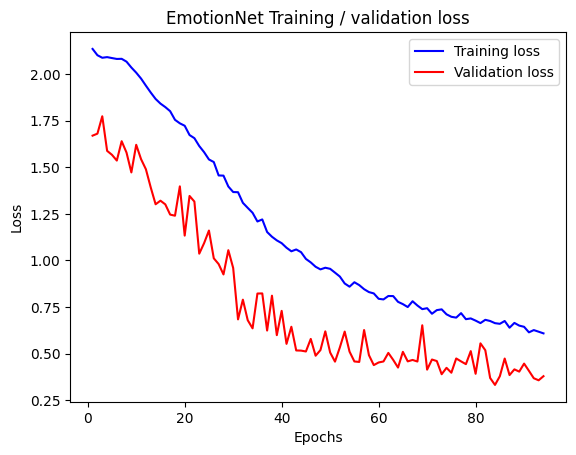

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('EmotionNet Training / validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

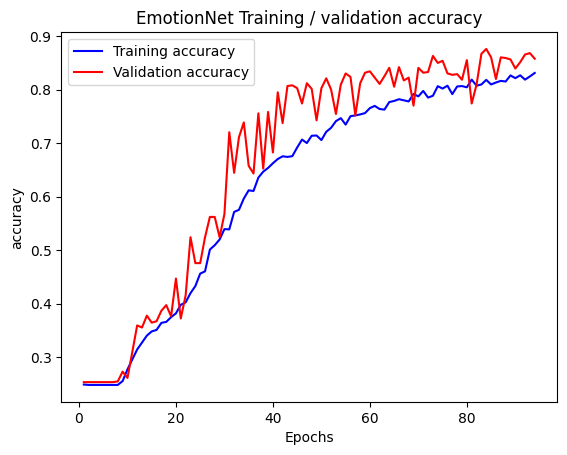

In [ ]:
import matplotlib.pyplot as plt

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('EmotionNet Training / validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Model Export

In [ ]:
model.save('/content/drive/MyDrive/Project/EmotionNet_weights45')

In [ ]:
EmotionNet_60ephochs = tf.keras.models.load_model('/content/drive/MyDrive/Project/EmotionNet_60ephochs')